<a href="https://colab.research.google.com/github/Lowestt/LAbexam2/blob/main/FINAL_LAB_2_GOMEZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
# Load the dataset
ionosphere_data = fetch_openml(name='ionosphere', version=1, as_frame=False)
X = ionosphere_data.data
y = ionosphere_data.target.astype('str')  # Convert target labels to strings
print("Dataset loaded.")


Dataset loaded.


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [25]:
# Define the classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Bagging': BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=10, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Ensemble model with Stacking
estimators = [
    ('knn', classifiers['KNN']),
    ('rf', classifiers['Random Forest']),
    ('svm', classifiers['SVM'])
]
classifiers['Stacking'] = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=5)

# Train and evaluate models using all features
results_all_features = {}
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None
    roc_auc = auc(*roc_curve(y_test_binary.ravel(), y_pred_proba[:, 1])[:2]) if y_pred_proba is not None else None
    results_all_features[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc
    }


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [26]:
# Feature selection using Recursive Feature Elimination (RFE) with RandomForest
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
X_train_selected = rfe_selector.fit_transform(X_train, y_train)
X_test_selected = rfe_selector.transform(X_test)

# Train and evaluate models using selected features
results_selected_features = {}
for name, clf in classifiers.items():
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    y_pred_proba = clf.predict_proba(X_test_selected) if hasattr(clf, "predict_proba") else None
    roc_auc = auc(*roc_curve(y_test_binary.ravel(), y_pred_proba[:, 1])[:2]) if y_pred_proba is not None else None
    results_selected_features[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc
    }


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [27]:
# Function to plot confusion matrices
def plot_confusion_matrices(results, title_suffix):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    for idx, (name, result) in enumerate(results.items()):
        cm = result['confusion_matrix']
        cm_percent = cm / np.sum(cm, axis=1, keepdims=True) * 100
        sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', xticklabels=['b', 'g'], yticklabels=['b', 'g'], ax=axes[idx])
        axes[idx].set_title(f'{name} {title_suffix}')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Function to plot ROC curves
def plot_roc_curves(results, title_suffix):
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        if result['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test_binary.ravel(), result['y_pred_proba'][:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} {title_suffix} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to print classification reports
def print_classification_reports(results, title_suffix):
    for name, result in results.items():
        print(f"\nClassification Report for {name} ({title_suffix}):")
        print(result['classification_report'])

# Function to plot accuracy and AUC scores
def plot_scores(results_all, results_selected, metric='accuracy'):
    labels = list(results_all.keys())
    scores_all = [results_all[name][metric] for name in labels]
    scores_selected = [results_selected[name][metric] for name in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, scores_all, width, label='All Features')
    rects2 = ax.bar(x + width/2, scores_selected, width, label='Selected Features')

    ax.set_xlabel('Model')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by model and feature set')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()


Results using all features:

Classification Report for KNN (all features):
{'b': {'precision': 1.0, 'recall': 0.5897435897435898, 'f1-score': 0.7419354838709677, 'support': 39}, 'g': {'precision': 0.8072289156626506, 'recall': 1.0, 'f1-score': 0.8933333333333333, 'support': 67}, 'accuracy': 0.8490566037735849, 'macro avg': {'precision': 0.9036144578313253, 'recall': 0.7948717948717949, 'f1-score': 0.8176344086021505, 'support': 106}, 'weighted avg': {'precision': 0.8781541259377132, 'recall': 0.8490566037735849, 'f1-score': 0.8376303509839723, 'support': 106}}

Classification Report for Random Forest (all features):
{'b': {'precision': 0.9722222222222222, 'recall': 0.8974358974358975, 'f1-score': 0.9333333333333333, 'support': 39}, 'g': {'precision': 0.9428571428571428, 'recall': 0.9850746268656716, 'f1-score': 0.9635036496350364, 'support': 67}, 'accuracy': 0.9528301886792453, 'macro avg': {'precision': 0.9575396825396825, 'recall': 0.9412552621507846, 'f1-score': 0.9484184914841849, 

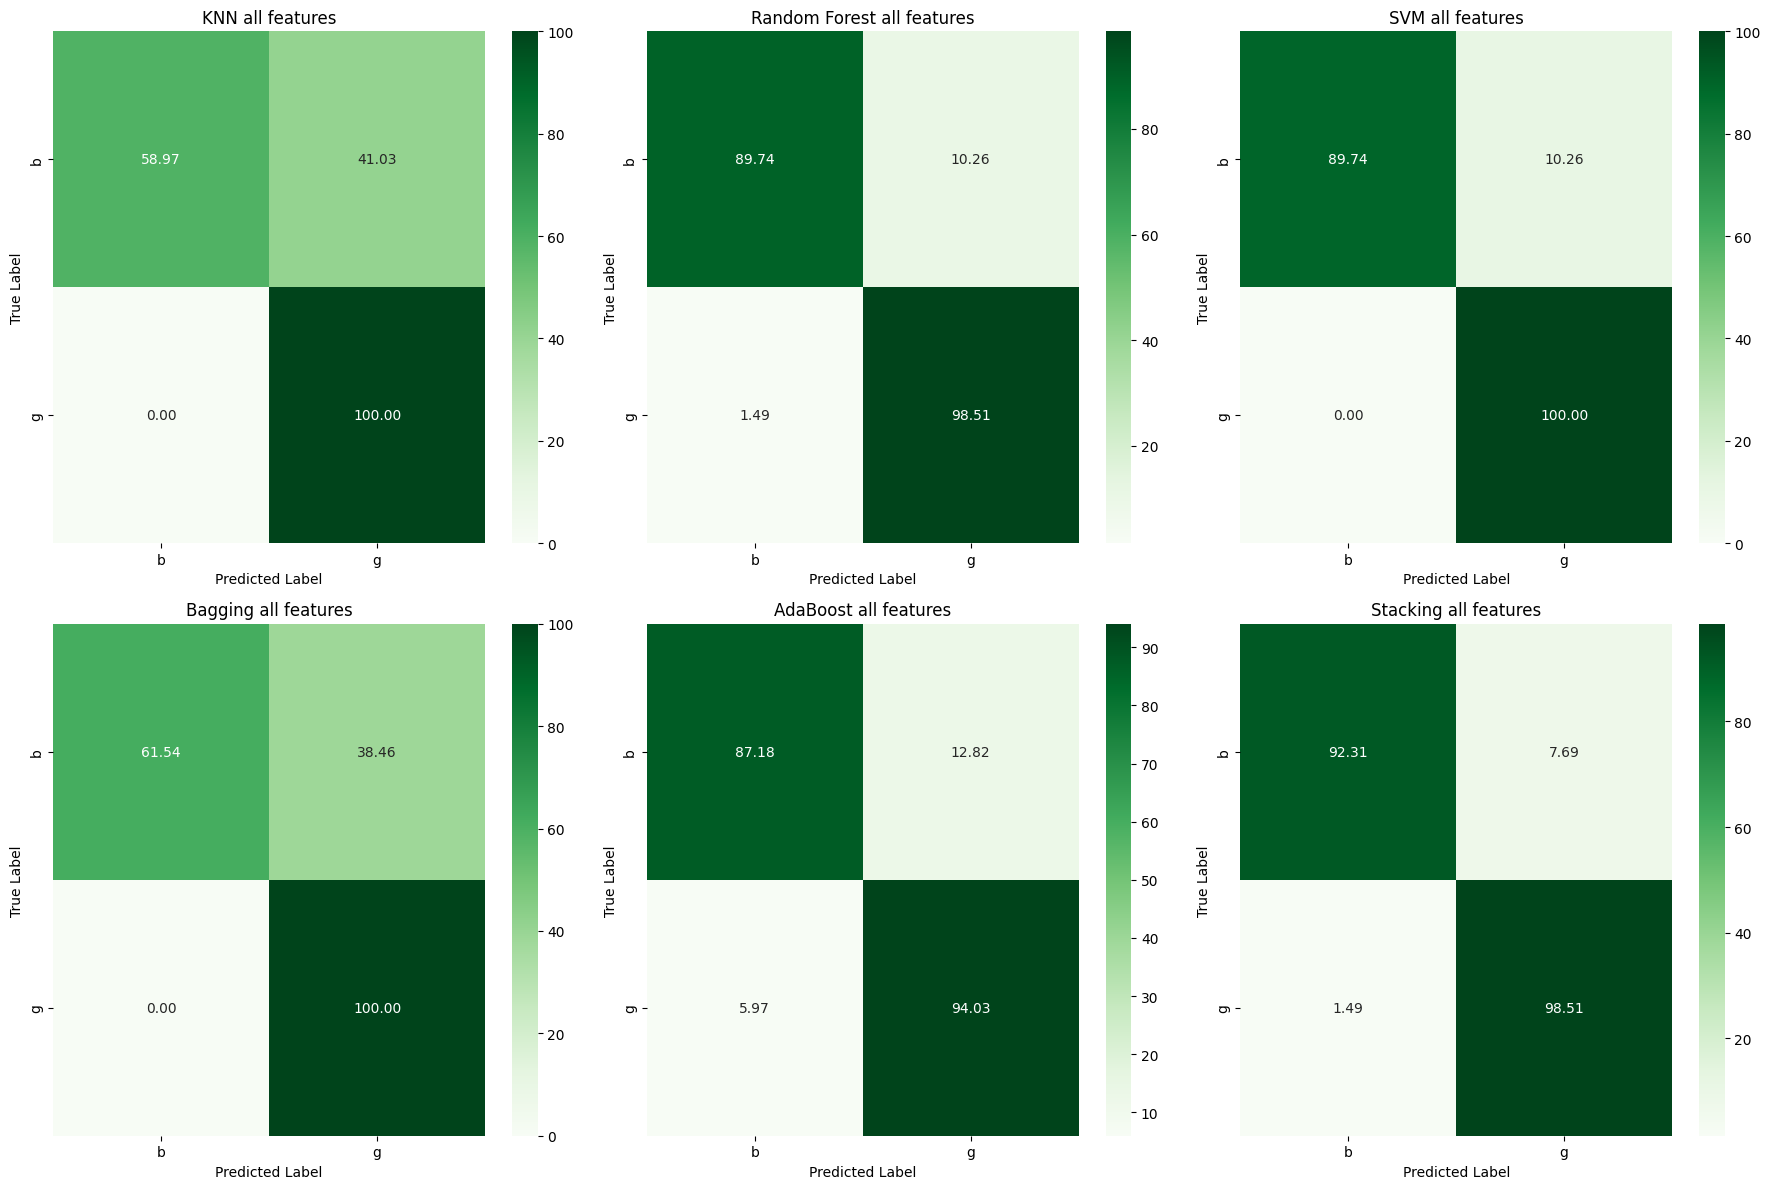

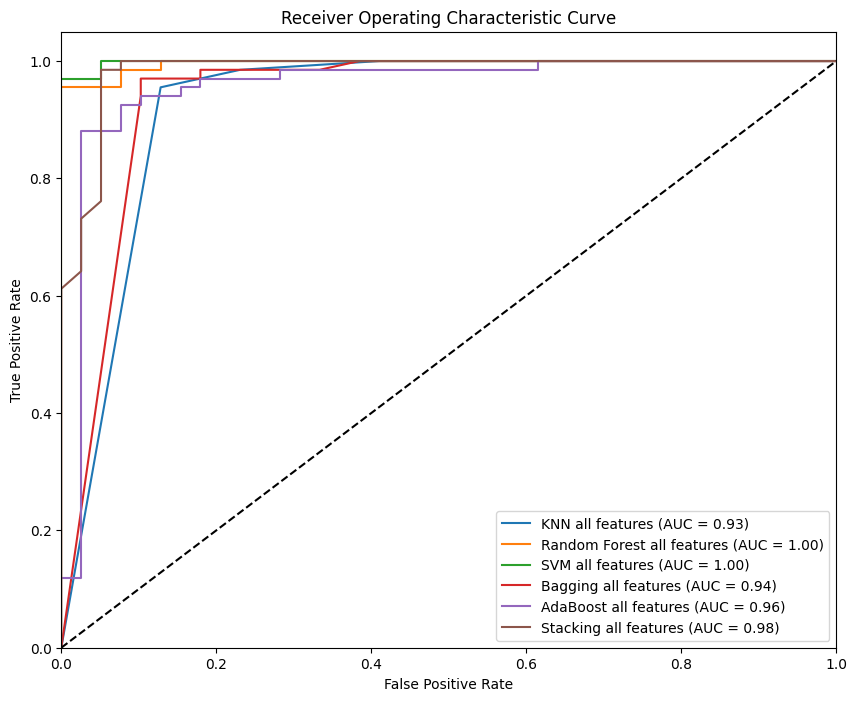

In [28]:
# Results using all features
print("Results using all features:")
print_classification_reports(results_all_features, "all features")
plot_confusion_matrices(results_all_features, "all features")
plot_roc_curves(results_all_features, "all features")


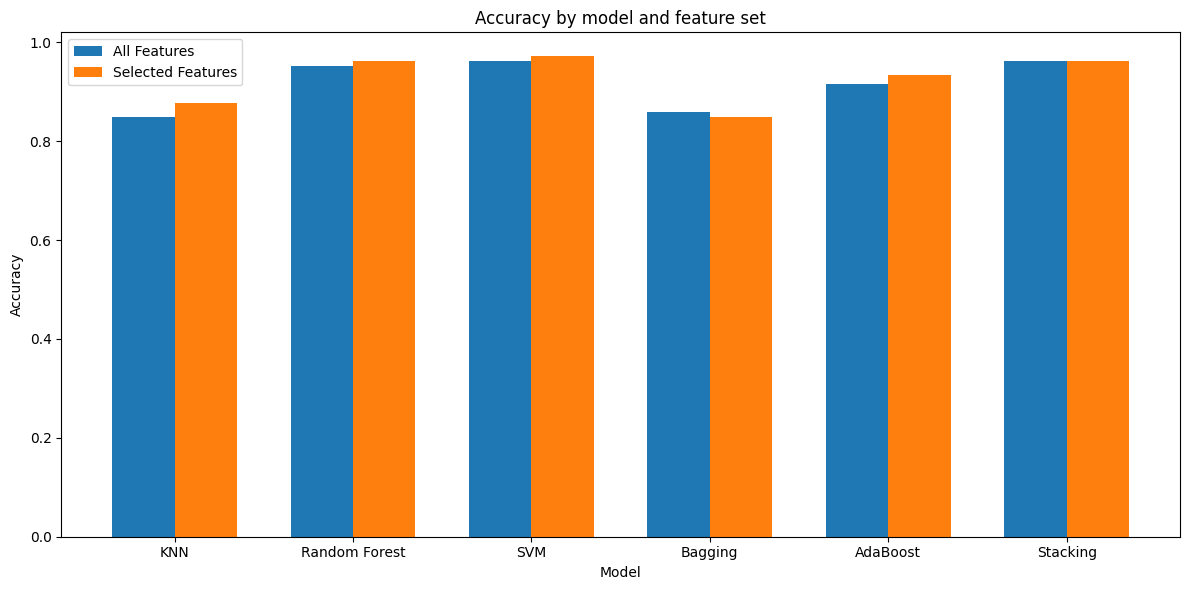

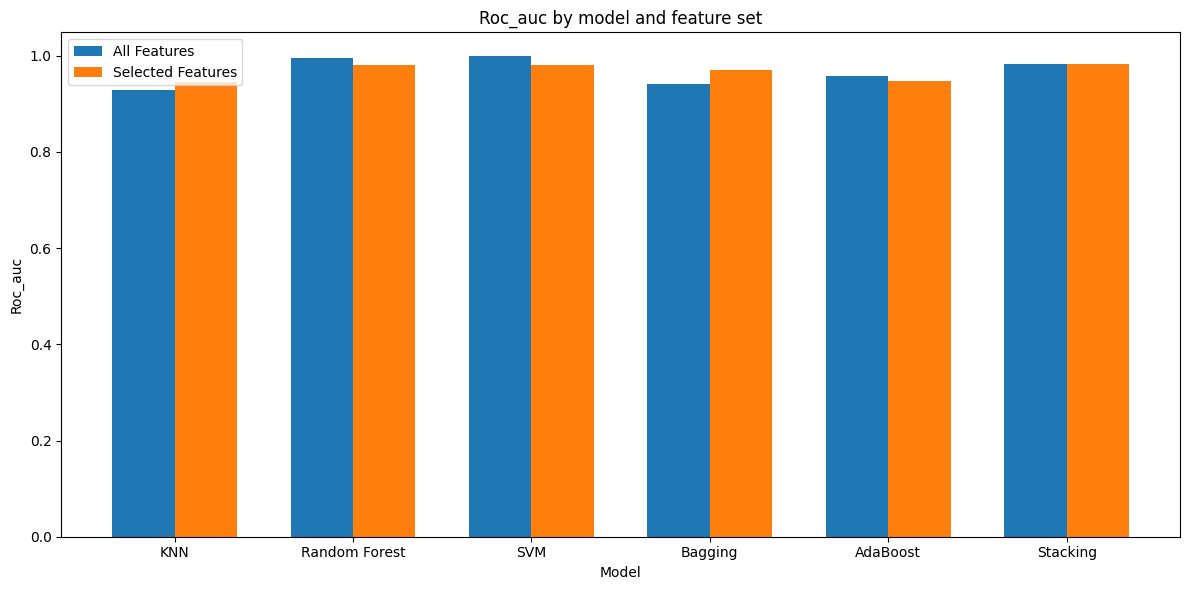

Best model using all features based on accuracy: SVM
Best model using all features based on AUC: SVM
Best model using selected features based on accuracy: SVM
Best model using selected features based on AUC: Stacking


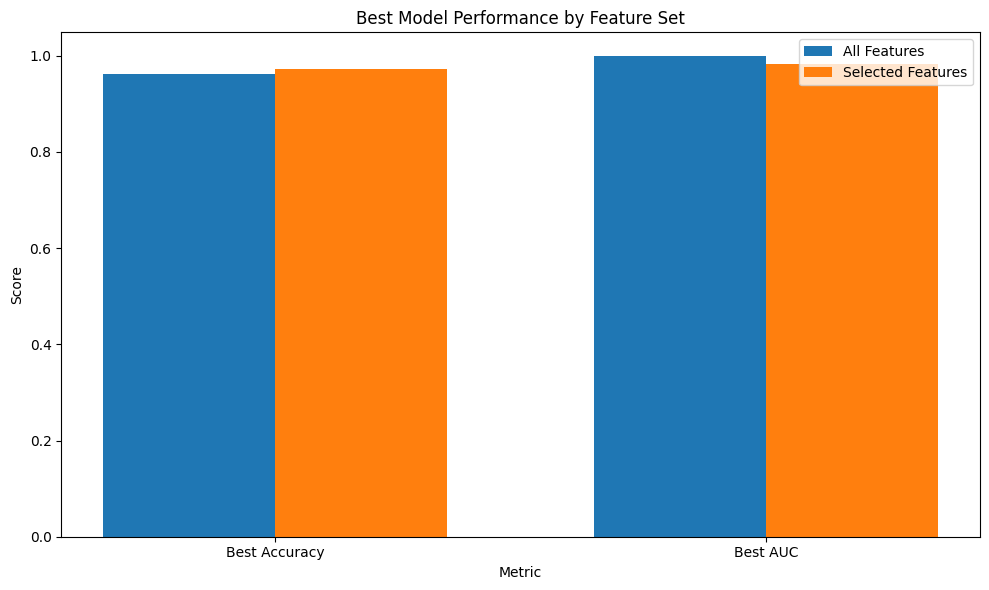

In [29]:
# Plot accuracy scores for all models
plot_scores(results_all_features, results_selected_features, metric='accuracy')

# Plot AUC scores for all models
plot_scores(results_all_features, results_selected_features, metric='roc_auc')

# Find the best model based on accuracy and AUC
best_model_accuracy_all = max(results_all_features, key=lambda x: results_all_features[x]['accuracy'])
best_model_auc_all = max(results_all_features, key=lambda x: results_all_features[x]['roc_auc'])
best_model_accuracy_selected = max(results_selected_features, key=lambda x: results_selected_features[x]['accuracy'])
best_model_auc_selected = max(results_selected_features, key=lambda x: results_selected_features[x]['roc_auc'])

print(f"Best model using all features based on accuracy: {best_model_accuracy_all}")
print(f"Best model using all features based on AUC: {best_model_auc_all}")
print(f"Best model using selected features based on accuracy: {best_model_accuracy_selected}")
print(f"Best model using selected features based on AUC: {best_model_auc_selected}")

# Plot bar graph showing best model performance
def plot_best_model_performance(results_all, results_selected):
    labels = ['Best Accuracy', 'Best AUC']
    scores_all = [results_all[best_model_accuracy_all]['accuracy'], results_all[best_model_auc_all]['roc_auc']]
    scores_selected = [results_selected[best_model_accuracy_selected]['accuracy'], results_selected[best_model_auc_selected]['roc_auc']]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, scores_all, width, label='All Features')
    rects2 = ax.bar(x + width/2, scores_selected, width, label='Selected Features')

    ax.set_xlabel('Metric')
    ax.set_ylabel('Score')
    ax.set_title('Best Model Performance by Feature Set')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

plot_best_model_performance(results_all_features, results_selected_features)


Best model using all features based on accuracy: SVM (96.23%)
Best model using all features based on AUC: SVM (99.85%)
Best model using selected features based on accuracy: SVM (97.17%)
Best model using selected features based on AUC: Stacking (98.24%)


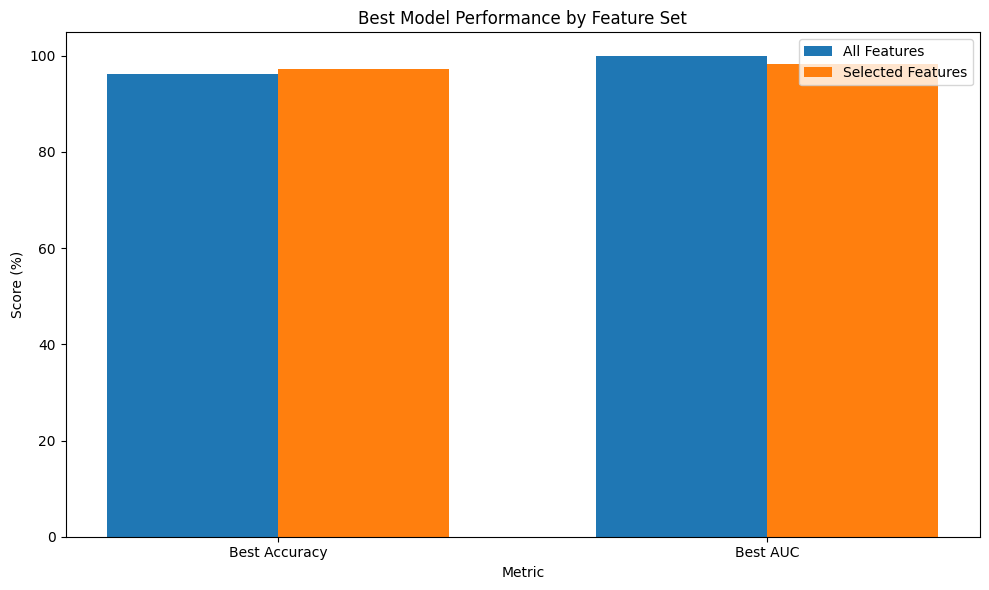

In [30]:
# Plot accuracy and AUC scores and identify best models

# Function to plot best model performance
def plot_best_model_performance(results_all, results_selected):
    labels = ['Best Accuracy', 'Best AUC']
    scores_all = [results_all[best_model_accuracy_all]['accuracy'] * 100, results_all[best_model_auc_all]['roc_auc'] * 100]
    scores_selected = [results_selected[best_model_accuracy_selected]['accuracy'] * 100, results_selected[best_model_auc_selected]['roc_auc'] * 100]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, scores_all, width, label='All Features')
    rects2 = ax.bar(x + width/2, scores_selected, width, label='Selected Features')

    ax.set_xlabel('Metric')
    ax.set_ylabel('Score (%)')
    ax.set_title('Best Model Performance by Feature Set')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

 #Find the best model based on accuracy and AUC
best_model_accuracy_all = max(results_all_features, key=lambda x: results_all_features[x]['accuracy'])
best_model_auc_all = max(results_all_features, key=lambda x: results_all_features[x]['roc_auc'])
best_model_accuracy_selected = max(results_selected_features, key=lambda x: results_selected_features[x]['accuracy'])
best_model_auc_selected = max(results_selected_features, key=lambda x: results_selected_features[x]['roc_auc'])

print(f"Best model using all features based on accuracy: {best_model_accuracy_all} ({results_all_features[best_model_accuracy_all]['accuracy'] * 100:.2f}%)")
print(f"Best model using all features based on AUC: {best_model_auc_all} ({results_all_features[best_model_auc_all]['roc_auc'] * 100:.2f}%)")
print(f"Best model using selected features based on accuracy: {best_model_accuracy_selected} ({results_selected_features[best_model_accuracy_selected]['accuracy'] * 100:.2f}%)")
print(f"Best model using selected features based on AUC: {best_model_auc_selected} ({results_selected_features[best_model_auc_selected]['roc_auc'] * 100:.2f}%)")

plot_best_model_performance(results_all_features, results_selected_features)
